In [1]:
# ============================================================
# 06_model_segmentation_eff_unet.ipynb
# Modèle de segmentation mains RSNA (EfficientNetB0 + UNet)
# ============================================================

# Cellule 1 : imports & chemins
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow version :", tf.__version__)

# On part du dossier Boneage
BASE_DIR = Path(".").resolve()
print("BASE_DIR :", BASE_DIR)

# Dossiers images & masques
IMAGES_DIR = BASE_DIR / "boneage-training-dataset" / "boneage-training-dataset"
MASKS_DIR  = BASE_DIR / "eff_unet"

print("IMAGES_DIR :", IMAGES_DIR)
print("MASKS_DIR  :", MASKS_DIR)

print("\nVérification dossiers :")
for d in [IMAGES_DIR, MASKS_DIR]:
    print(f"{d} -> {'OK' if d.exists() else 'ABSENT'}")


2025-11-30 21:26:50.503102: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 21:26:50.511398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 21:26:50.522373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 21:26:50.525664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 21:26:50.534060: I tensorflow/core/platform/cpu_feature_guar

TensorFlow version : 2.17.0
BASE_DIR : /home/fabrice/Boneage
IMAGES_DIR : /home/fabrice/Boneage/boneage-training-dataset/boneage-training-dataset
MASKS_DIR  : /home/fabrice/Boneage/eff_unet

Vérification dossiers :
/home/fabrice/Boneage/boneage-training-dataset/boneage-training-dataset -> OK
/home/fabrice/Boneage/eff_unet -> OK


In [2]:
# ============================================================
# Cellule 2 : chargement des CSV
# ============================================================

CSV_CLEAN = BASE_DIR / "boneage-training-dataset-cleaned-v3.csv"
CSV_TRAIN = BASE_DIR / "boneage_train_final_v3.csv"
CSV_VAL   = BASE_DIR / "boneage_val_v3.csv"
CSV_TEST  = BASE_DIR / "boneage_test_v3.csv"

print("CSV :")
for path in [CSV_CLEAN, CSV_TRAIN, CSV_VAL, CSV_TEST]:
    print(f"{path.name:<35} -> {'OK' if path.exists() else 'ABSENT'}")

if not CSV_CLEAN.exists():
    raise FileNotFoundError(f"{CSV_CLEAN} introuvable")

clean_df = pd.read_csv(CSV_CLEAN)
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

print("\nColonnes CLEAN :", clean_df.columns.tolist())
print("Colonnes TRAIN :", train_df.columns.tolist())

print("\nAperçu CLEAN :")
display(clean_df.head())

print("\nAperçu TRAIN :")
display(train_df.head())


CSV :
boneage-training-dataset-cleaned-v3.csv -> OK
boneage_train_final_v3.csv          -> OK
boneage_val_v3.csv                  -> OK
boneage_test_v3.csv                 -> OK

Colonnes CLEAN : ['id', 'boneage', 'male']
Colonnes TRAIN : ['id', 'boneage', 'male', 'age_bin', 'strata']

Aperçu CLEAN :


,id,boneage,male
0,1377,180,False
1,1380,120,True
2,1382,138,True
3,1385,36,True
4,1387,138,True



Aperçu TRAIN :


,id,boneage,male,age_bin,strata
0,12380,156,True,144-161,True_144-161
1,9535,120,False,108-125,False_108-125
2,12319,106,False,90-107,False_90-107
3,10433,94,False,90-107,False_90-107
4,9223,82,False,72-89,False_72-89


In [3]:
# ============================================================
# Cellule 3 : chemins des PNG (images & masques)
# ============================================================

IMAGE_COL = "id"  # colonne identifiant l'image/mask (ex: 1377)

def build_image_path(filename: str) -> Path:
    fname = str(filename)
    if not fname.lower().endswith(".png"):
        fname = f"{fname}.png"
    return IMAGES_DIR / fname

def build_mask_path(filename: str) -> Path:
    fname = str(filename)
    if not fname.lower().endswith(".png"):
        fname = f"{fname}.png"
    return MASKS_DIR / fname

for df in (train_df, val_df, test_df):
    df["image_path"] = df[IMAGE_COL].apply(lambda x: str(build_image_path(x)))
    df["mask_path"]  = df[IMAGE_COL].apply(lambda x: str(build_mask_path(x)))

print("Exemple chemins TRAIN :")
display(train_df[["id", "image_path", "mask_path"]].head())

# Vérification existence (robustesse)
def check_paths(df, n=10):
    missing_img = []
    missing_mask = []
    for _, row in df.iterrows():
        if not Path(row["image_path"]).exists():
            missing_img.append(row["image_path"])
        if not Path(row["mask_path"]).exists():
            missing_mask.append(row["mask_path"])
    print(f"Images manquantes : {len(missing_img)}")
    print(f"Masques manquants : {len(missing_mask)}")
    if missing_img[:n]:
        print("Ex. images manquantes :", missing_img[:n])
    if missing_mask[:n]:
        print("Ex. masques manquants :", missing_mask[:n])

print("\nVérification TRAIN :")
check_paths(train_df)
print("\nVérification VAL :")
check_paths(val_df)
print("\nVérification TEST :")
check_paths(test_df)


Exemple chemins TRAIN :


,id,image_path,mask_path
0,12380,/home/fabrice/Boneage/boneage-training-dataset...,/home/fabrice/Boneage/eff_unet/12380.png
1,9535,/home/fabrice/Boneage/boneage-training-dataset...,/home/fabrice/Boneage/eff_unet/9535.png
2,12319,/home/fabrice/Boneage/boneage-training-dataset...,/home/fabrice/Boneage/eff_unet/12319.png
3,10433,/home/fabrice/Boneage/boneage-training-dataset...,/home/fabrice/Boneage/eff_unet/10433.png
4,9223,/home/fabrice/Boneage/boneage-training-dataset...,/home/fabrice/Boneage/eff_unet/9223.png



Vérification TRAIN :
Images manquantes : 0
Masques manquants : 0

Vérification VAL :
Images manquantes : 0
Masques manquants : 0

Vérification TEST :
Images manquantes : 0
Masques manquants : 0


In [4]:
# ============================================================
# Cellule 4 : tf.data.Dataset (chargement + augmentations)
# ============================================================

IMG_SIZE = 224
BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

def load_image_and_mask(image_path, mask_path):
    # ----- IMAGE (radiographie) -----
    img_bytes = tf.io.read_file(image_path)
    # Chargement en 1 canal
    img = tf.image.decode_png(img_bytes, channels=1)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # Conversion GRAY -> RGB pour EfficientNet (3 canaux)
    img = tf.image.grayscale_to_rgb(img)  # (H, W, 3)

    # On laisse en [0..255] float32, EffNet fera son preprocess
    img = tf.cast(img, tf.float32)

    # ----- MASQUE (1 canal binaire) -----
    mask_bytes = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask_bytes, channels=1)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method="nearest")
    mask = tf.cast(mask > 127, tf.float32)  # 0/1

    return img, mask

def augment_image_and_mask(img, mask):
    # Flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    # Légère variation de contraste (robuste, mais douce)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    return img, mask

def make_dataset(df, shuffle=True, augment=True):
    img_paths = df["image_path"].values
    mask_paths = df["mask_path"].values

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    def _map_fn(img_p, mask_p):
        img, mask = load_image_and_mask(img_p, mask_p)
        if augment:
            img, mask = augment_image_and_mask(img, mask)
        return img, mask

    ds = ds.map(_map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True,  augment=True)
val_ds   = make_dataset(val_df,   shuffle=False, augment=False)
test_ds  = make_dataset(test_df,  shuffle=False, augment=False)

# Vérification shapes
sample_img, sample_mask = next(iter(train_ds))
print("Sample image shape :", sample_img[0].shape)  # (224,224,3)
print("Sample mask  shape :", sample_mask[0].shape) # (224,224,1)


I0000 00:00:1764538012.525925  100263 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764538012.578187  100263 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764538012.578267  100263 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764538012.579966  100263 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1764538012.580071  100263 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Sample image shape : (224, 224, 3)
Sample mask  shape : (224, 224, 1)


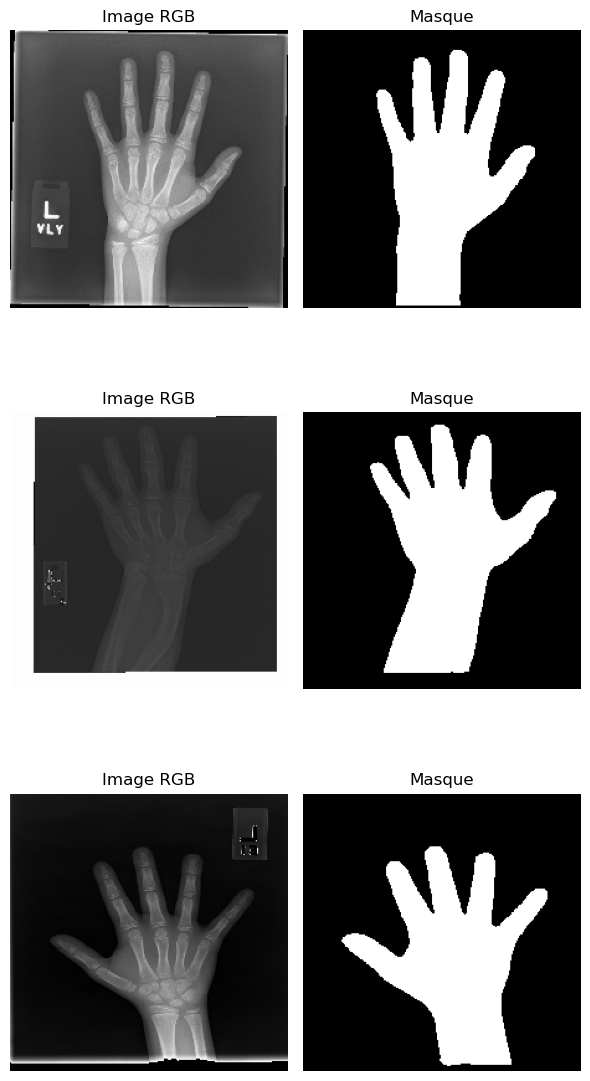

In [5]:
# ============================================================
# Cellule 5 : visualisation de quelques paires image/masque
# ============================================================

def show_samples(dataset, n=3):
    imgs, masks = next(iter(dataset))
    plt.figure(figsize=(6, 4 * n))
    for i in range(n):
        plt.subplot(n, 2, 2*i + 1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title("Image RGB")
        plt.axis("off")

        plt.subplot(n, 2, 2*i + 2)
        plt.imshow(masks[i,...,0].numpy(), cmap="gray")
        plt.title("Masque")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(train_ds, n=3)


In [6]:
# ============================================================
# Cellule 6 — Modèle U-Net avec ResNet50 (solution robuste)
# ============================================================

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers, Model, Input

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def build_resnet_unet(input_shape=IMG_SHAPE):

    inputs = Input(shape=input_shape, name="image_input")

    # Preprocess ResNet (RGB en 0..255)
    x = preprocess_input(inputs)

    # Encoder ResNet50
    backbone = ResNet50(
        include_top=False,
        weights="imagenet",
        input_tensor=x
    )

    # Skip connections stables, garanties
    skip1 = backbone.get_layer("conv1_relu").output        # 112×112
    skip2 = backbone.get_layer("conv2_block3_out").output  # 56×56
    skip3 = backbone.get_layer("conv3_block4_out").output  # 28×28
    skip4 = backbone.get_layer("conv4_block6_out").output  # 14×14
    
    encoder_output = backbone.get_layer("conv5_block3_out").output  # 7×7

    # Decoder UNet
    y = encoder_output
    decoder_filters = [512, 256, 128, 64]

    for filters, skip in zip(decoder_filters, [skip4, skip3, skip2, skip1]):
        y = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(y)
        y = layers.Concatenate()([y, skip])
        y = layers.BatchNormalization()(y)
        y = layers.Activation("relu")(y)
        y = layers.Conv2D(filters, 3, padding="same", activation="relu")(y)

    # Final upsampling (224×224)
    y = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(y)
    y = layers.BatchNormalization()(y)
    y = layers.Activation("relu")(y)
    y = layers.Conv2D(32, 3, padding="same", activation="relu")(y)

    outputs = layers.Conv2D(
        1, 1, activation="sigmoid", name="mask_output"
    )(y)

    model = Model(inputs, outputs, name="ResNet50_UNet_seg")
    return model

# Construction & résumé
model = build_resnet_unet()
model.summary()

print("Backbone:", "ResNet50")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "ResNet50_UNet_seg"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ image_input[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ image_input[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ add[0][0]         │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c

 Total params: 43,977,697 (167.76 MB)

 Trainable params: 43,918,881 (167.54 MB)

 Non-trainable params: 58,816 (229.75 KB)

Backbone: ResNet50


In [7]:
# ============================================================
# Cellule 7 : loss & metrics
# ============================================================

# Dice coefficient
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Combinaison BCE + Dice
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

metrics_list = [
    dice_coef,
    tf.keras.metrics.BinaryAccuracy(),
]


In [8]:
# ============================================================
# Cellule 8 : Callbacks
# ============================================================

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "seg_model_best.keras",
    monitor="val_dice_coef",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_cb = keras.callbacks.EarlyStopping(
    monitor="val_dice_coef",
    patience=10,
    mode="max",
    restore_best_weights=True,
    verbose=1
)

tensorboard_cb = keras.callbacks.TensorBoard(
    log_dir="logs_segmentation_v1",
    update_freq="epoch"
)


In [9]:
# ============================================================
# Cellule 9 : Phase 1 — Backbone gelé
# ============================================================

# On gèle tout le backbone ResNet50
for layer in model.layers:
    if "resnet" in layer.name.lower() or "conv" in layer.name.lower():
        layer.trainable = False

optimizer_phase1 = keras.optimizers.Adam(1e-4)

model.compile(
    optimizer=optimizer_phase1,
    loss=bce_dice_loss,
    metrics=metrics_list
)

print("=== Phase 1 : entraînement UNet head only ===")
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, early_cb, tensorboard_cb]
)


=== Phase 1 : entraînement UNet head only ===
Epoch 1/20


I0000 00:00:1764538386.948328  100332 service.cc:146] XLA service 0x792ca0056a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764538386.948480  100332 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-30 21:33:07.176648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-30 21:33:08.024154: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 91200
2025-11-30 21:33:17.345966: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_8', 660 bytes spill stores, 608 bytes spill loads

I0000 00:00:1764538397.366479  100332 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - binary_accuracy: 0.5580 - dice_coef: 0.4049 - loss: 1.2947

2025-11-30 21:34:24.184045: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 660 bytes spill stores, 608 bytes spill loads




Epoch 1: val_dice_coef improved from None to 0.43190, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 100s 88ms/step - binary_accuracy: 0.6328 - dice_coef: 0.4109 - loss: 1.2574 - val_binary_accuracy: 0.7426 - val_dice_coef: 0.4319 - val_loss: 1.1762
Epoch 2/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - binary_accuracy: 0.7705 - dice_coef: 0.4550 - loss: 1.1206
Epoch 2: val_dice_coef improved from 0.43190 to 0.53346, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - binary_accuracy: 0.7928 - dice_coef: 0.4801 - loss: 1.0614 - val_binary_accuracy: 0.8273 - val_dice_coef: 0.5335 - val_loss: 0.9403
Epoch 3/20
962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - binary_accuracy: 0.8397 - dice_coef: 0.5599 - loss: 0.8857
Epoch 3: val_dice_coef improved from 0.53346 to 0.63769, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - binary_accuracy: 0.8486 - dice_coef: 0.5864 - loss: 0.8325 - val_binary_accuracy: 0.8638 - v

In [10]:
# ============================================================
# Cellule 10 : Dégel progressif
# ============================================================

# Dégel partiel du backbone : uniquement block 5 (plus profond, utile)
for layer in model.layers:
    if "conv5" in layer.name.lower():
        layer.trainable = True

# On garde tout le reste gelé
trainable_count = sum([l.trainable for l in model.layers])
print("Layers now trainable :", trainable_count)

optimizer_phase2 = keras.optimizers.Adam(1e-5)
model.compile(
    optimizer=optimizer_phase2,
    loss=bce_dice_loss,
    metrics=metrics_list
)

print("=== Phase 2 : fine-tuning partiel du backbone ===")
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, early_cb, tensorboard_cb]
)


Layers now trainable : 50
=== Phase 2 : fine-tuning partiel du backbone ===
Epoch 1/30


2025-11-30 22:26:34.467459: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_14', 660 bytes spill stores, 608 bytes spill loads



962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - binary_accuracy: 0.9842 - dice_coef: 0.9661 - loss: 0.0747

2025-11-30 22:27:51.611410: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_13', 660 bytes spill stores, 608 bytes spill loads



963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - binary_accuracy: 0.9842 - dice_coef: 0.9661 - loss: 0.0747
Epoch 1: val_dice_coef improved from 0.96601 to 0.96852, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 104s 93ms/step - binary_accuracy: 0.9844 - dice_coef: 0.9667 - loss: 0.0730 - val_binary_accuracy: 0.9857 - val_dice_coef: 0.9685 - val_loss: 0.0679
Epoch 2/30
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - binary_accuracy: 0.9854 - dice_coef: 0.9682 - loss: 0.0689
Epoch 2: val_dice_coef improved from 0.96852 to 0.96966, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 82s 85ms/step - binary_accuracy: 0.9855 - dice_coef: 0.9683 - loss: 0.0685 - val_binary_accuracy: 0.9864 - val_dice_coef: 0.9697 - val_loss: 0.0649
Epoch 3/30
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - binary_accuracy: 0.9859 - dice_coef: 0.9690 - loss: 0.0668
Epoch 3: val_dice_coef improved from 0.96966 to 0.97028, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 87s

In [11]:
# ============================================================
# Cellule 11 : Dégel complet - si pas de divergence avant (optionnel)
# ============================================================

for layer in model.layers:
    layer.trainable = True

optimizer_phase3 = keras.optimizers.Adam(5e-6)

model.compile(
    optimizer=optimizer_phase3,
    loss=bce_dice_loss,
    metrics=metrics_list
)

print("=== Phase 3 : fine-tuning complet ===")
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cb, early_cb]
)


=== Phase 3 : fine-tuning complet ===
Epoch 1/20


2025-12-01 02:32:18.973516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_49', 160 bytes spill stores, 160 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 1112 bytes spill stores, 984 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_44', 728 bytes spill stores, 692 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 36 bytes spill stores, 36 bytes spill loads



962/963 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - binary_accuracy: 0.9894 - dice_coef: 0.9755 - loss: 0.0554

2025-12-01 02:34:43.587838: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_49', 160 bytes spill stores, 160 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 1112 bytes spill stores, 984 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_43', 728 bytes spill stores, 692 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_18', 36 bytes spill stores, 36 bytes spill loads



963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - binary_accuracy: 0.9894 - dice_coef: 0.9755 - loss: 0.0553
Epoch 1: val_dice_coef improved from 0.97890 to 0.98640, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 5806s 163ms/step - binary_accuracy: 0.9910 - dice_coef: 0.9817 - loss: 0.0407 - val_binary_accuracy: 0.9931 - val_dice_coef: 0.9864 - val_loss: 0.0310
Epoch 2/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - binary_accuracy: 0.9943 - dice_coef: 0.9882 - loss: 0.0258
Epoch 2: val_dice_coef improved from 0.98640 to 0.98998, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━━━━ 136s 141ms/step - binary_accuracy: 0.9947 - dice_coef: 0.9890 - loss: 0.0241 - val_binary_accuracy: 0.9951 - val_dice_coef: 0.9900 - val_loss: 0.0229
Epoch 3/20
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - binary_accuracy: 0.9954 - dice_coef: 0.9907 - loss: 0.0207
Epoch 3: val_dice_coef improved from 0.98998 to 0.99131, saving model to seg_model_best.keras
963/963 ━━━━━━━━━━━━━━━━━

In [12]:
# ============================================================
# Cellule 12 : Évaluation finale
# ============================================================

best_model = keras.models.load_model(
    "seg_model_best.keras",
    custom_objects={"dice_coef": dice_coef, "bce_dice_loss": bce_dice_loss}
)

print("Evaluation sur test set :")
best_model.evaluate(test_ds)


Evaluation sur test set :
284/284 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - binary_accuracy: 0.9971 - dice_coef: 0.9946 - loss: 0.0137


[0.013694957830011845, 0.9946385622024536, 0.9971486926078796]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


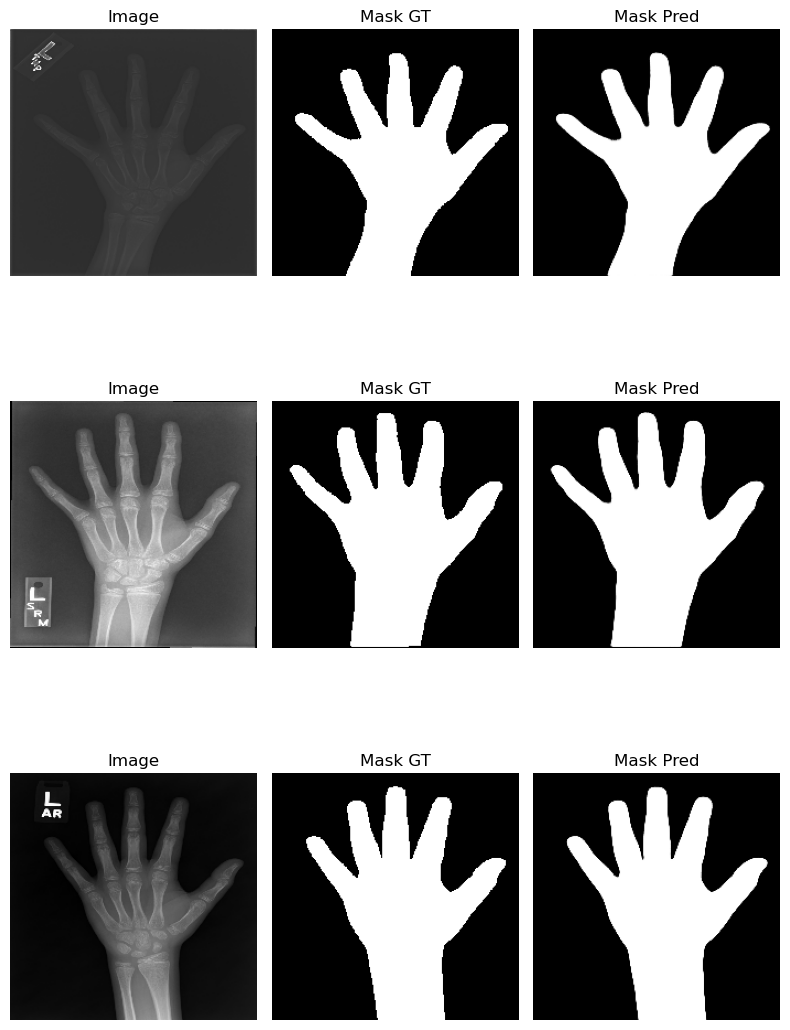

In [13]:
# ============================================================
# Cellule 13 : exemples de prédictions
# ============================================================

import random

def show_pred(n=3):
    imgs, masks = next(iter(test_ds))
    preds = best_model.predict(imgs)

    plt.figure(figsize=(8, 4*n))
    for i in range(n):
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(masks[i,...,0].numpy(), cmap="gray")
        plt.title("Mask GT")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(preds[i,...,0], cmap="gray")
        plt.title("Mask Pred")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_pred(3)


In [10]:
import os
print(os.path.getsize("seg_model_best.keras") / 1024**2, "MB")


503.70820236206055 MB
